In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
from sklearn.base import clone

import matplotlib.pyplot as plt

from core import *

from config import image_stats_file, aggregated_results_file, adjusted_scores_file, xls_file

pd.set_option('display.max_rows', None)

In [2]:
data= pd.read_csv(image_stats_file)
results= pd.read_csv(aggregated_results_file)
results.index= results['key']

methods= pd.read_excel(xls_file, engine='openpyxl')
#methods= methods.iloc[:methods[methods['key'].isnull()].index[0]]

# reading the image level figures
xl= pd.ExcelFile(xls_file, engine='openpyxl')
image_level= {}
for s in xl.sheet_names[1:]:
    image_level[s]= xl.parse(s)

In [3]:
data_with_fov= data[(data['test'] == True) & (data['ground_truth'] == 1) & (data['fov'] == True)].sort_values('id').reset_index()
data_without_fov= data[(data['test'] == True) & (data['ground_truth'] == 1) & (data['fov'] == False)].sort_values('id').reset_index()

In [4]:
p= data_with_fov['p'].values
tp= data_with_fov['tp'].values
n= data_with_fov['n'].values
tn= data_with_fov['tn'].values

p_all= data_without_fov['p'].values
n_all= data_without_fov['n'].values

In [5]:
results.columns

Index(['key', 'flag', 'year', 'all_previous_processed', 'acc', 'sens', 'spec',
       'digits', 'highest_ranked', 'second_human_observer', 'second_human_acc',
       'second_human_sens', 'second_human_spec', 'image_level',
       'short_description', 'operating_principles', 'citations',
       'explicit_fov_usage', 'invalid_ranking', 'cause_of_invalid_ranking',
       'image_level_consistency_with_fov',
       'image_level_consistency_without_fov', 'n_image_level', 'category',
       'n_aggregated_scores', 'consistency_with_fov_mor',
       'consistency_without_fov_mor', 'consistency_with_fov_rom',
       'consistency_without_fov_rom', 'consistency_with_fov',
       'consistency_without_fov', 'category_agg', 'category_final'],
      dtype='object')

In [6]:
for i, row in results.iterrows():
    if row['category_final'] == 'no FoV':
        results.loc[i, ['aggregated_adj_acc', 'aggregated_adj_acc_delta']]= score_range_aggregated(p, n, p_all - p, n_all - n, row['acc'], row['sens'], row['spec'], 10.0**(-row['digits']), n_all - n - 0.01*p, score='acc')
        results.loc[i, ['aggregated_adj_spec', 'aggregated_adj_spec_delta']]= score_range_aggregated(p, n, p_all - p, n_all - n, row['acc'], row['sens'], row['spec'], 10.0**(-row['digits']), n_all - n - 0.01*p, score='spec')
        results.loc[i, ['aggregated_adj_sens', 'aggregated_adj_sens_delta']]= score_range_aggregated(p, n, p_all - p, n_all - n, row['acc'], row['sens'], row['spec'], 10.0**(-row['digits']), n_all - n - 0.01*p, score='sens')
        

In [7]:
for i in image_level:
    if (not i in results.index) or (results.loc[i, 'category_final'] != 'no FoV'):
        continue
    if len(image_level[i]) == 20 and results.loc[i, 'image_level_consistency_without_fov'] == 1:
        values= [score_range_image_level(p[j], n[j], p_all[j] - p[j], n_all[j] - n[j], 
                                        row['acc'], row['sens'], row['spec'], 
                                        10.0**(-results.loc[i, 'digits']), 
                                        n_all[j] - n[j] - 0.01*p[j], score='acc') for j, row in image_level[i].reset_index(drop=True).iterrows()]
        results.loc[i, ['image_level_adj_acc', 'image_level_adj_acc_delta']]= np.mean(np.array(values), axis=0)

        values= [score_range_image_level(p[j], n[j], p_all[j] - p[j], n_all[j] - n[j], 
                                        row['acc'], row['sens'], row['spec'], 
                                        10.0**(-results.loc[i, 'digits']), 
                                        n_all[j] - n[j] - 0.01*p[j], score='spec') for j, row in image_level[i].reset_index(drop=True).iterrows()]
        results.loc[i, ['image_level_adj_spec', 'image_level_adj_spec_delta']]= np.mean(np.array(values), axis=0)

        values= [score_range_image_level(p[j], n[j], p_all[j] - p[j], n_all[j] - n[j], 
                                        row['acc'], row['sens'], row['spec'], 
                                        10.0**(-results.loc[i, 'digits']), 
                                        n_all[j] - n[j] - 0.01*p[j], score='sens') for j, row in image_level[i].reset_index(drop=True).iterrows()]
        results.loc[i, ['image_level_adj_sens', 'image_level_adj_sens_delta']]= np.mean(np.array(values), axis=0)

    elif len(image_level[i]) == 40 and results.loc[i, 'image_level_consistency_without_fov'] == 1:
        values= [score_range_image_level(p[j], n[j], p_all[j] - p[j], n_all[j] - n[j], 
                                        row['acc'], row['sens'], row['spec'], 
                                        10.0**(-results.loc[i, 'digits']), 
                                        n_all[j] - n[j] - 0.01*p[j], score='acc') for j, row in image_level[i].iloc[::2,:].reset_index(drop=True).iterrows()]
        results.loc[i, ['image_level_adj_acc', 'image_level_adj_acc_delta']]= np.mean(np.array(values), axis=0)

        values= [score_range_image_level(p[j], n[j], p_all[j] - p[j], n_all[j] - n[j], 
                                        row['acc'], row['sens'], row['spec'], 
                                        10.0**(-results.loc[i, 'digits']), 
                                        n_all[j] - n[j] - 0.01*p[j], score='spec') for j, row in image_level[i].iloc[::2,:].reset_index(drop=True).iterrows()]
        results.loc[i, ['image_level_adj_spec', 'image_level_adj_spec_delta']]= np.mean(np.array(values), axis=0)

        values= [score_range_image_level(p[j], n[j], p_all[j] - p[j], n_all[j] - n[j], 
                                        row['acc'], row['sens'], row['spec'], 
                                        10.0**(-results.loc[i, 'digits']), 
                                        n_all[j] - n[j] - 0.01*p[j], score='sens') for j, row in image_level[i].iloc[::2,:].reset_index(drop=True).iterrows()]
        results.loc[i, ['image_level_adj_sens', 'image_level_adj_sens_delta']]= np.mean(np.array(values), axis=0)


In [8]:
results.columns

Index(['key', 'flag', 'year', 'all_previous_processed', 'acc', 'sens', 'spec',
       'digits', 'highest_ranked', 'second_human_observer', 'second_human_acc',
       'second_human_sens', 'second_human_spec', 'image_level',
       'short_description', 'operating_principles', 'citations',
       'explicit_fov_usage', 'invalid_ranking', 'cause_of_invalid_ranking',
       'image_level_consistency_with_fov',
       'image_level_consistency_without_fov', 'n_image_level', 'category',
       'n_aggregated_scores', 'consistency_with_fov_mor',
       'consistency_without_fov_mor', 'consistency_with_fov_rom',
       'consistency_without_fov_rom', 'consistency_with_fov',
       'consistency_without_fov', 'category_agg', 'category_final',
       'aggregated_adj_acc', 'aggregated_adj_acc_delta', 'aggregated_adj_spec',
       'aggregated_adj_spec_delta', 'aggregated_adj_sens',
       'aggregated_adj_sens_delta', 'image_level_adj_acc',
       'image_level_adj_acc_delta', 'image_level_adj_spec',
      

In [9]:
results[['aggregated_adj_acc', 'image_level_adj_acc', 'aggregated_adj_sens', 'image_level_adj_sens', 'aggregated_adj_spec', 'image_level_adj_spec', 'image_level_consistency_without_fov']]

,aggregated_adj_acc,image_level_adj_acc,aggregated_adj_sens,image_level_adj_sens,aggregated_adj_spec,image_level_adj_spec,image_level_consistency_without_fov
key,,,,,,,
adapa2020,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
alom2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anzalone2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
azzopardi2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
barkana2017,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
brancati2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
budai2013,0.938084,NaN,0.644090,NaN,0.980835,NaN,NaN
chalakkal2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cheng2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
results[['acc', 'spec', 'sens', 'aggregated_adj_acc', 'aggregated_adj_acc_delta', 'aggregated_adj_sens', 'aggregated_adj_sens_delta', 'aggregated_adj_spec', 'aggregated_adj_spec_delta', 'image_level_adj_acc', 'image_level_adj_acc_delta', 'image_level_adj_sens', 'image_level_adj_sens_delta', 'image_level_adj_spec', 'image_level_adj_spec_delta']].mean()

acc                           0.953966
spec                          0.978239
sens                          0.755007
aggregated_adj_acc            0.938536
aggregated_adj_acc_delta      0.001181
aggregated_adj_sens           0.739160
aggregated_adj_sens_delta     0.000522
aggregated_adj_spec           0.967991
aggregated_adj_spec_delta     0.001323
image_level_adj_acc           0.933010
image_level_adj_acc_delta     0.000978
image_level_adj_sens          0.725249
image_level_adj_sens_delta    0.000481
image_level_adj_spec          0.963636
image_level_adj_spec_delta    0.001079
dtype: float64

In [11]:
results[['aggregated_adj_acc_delta', 'aggregated_adj_sens_delta', 'aggregated_adj_spec_delta', 'image_level_adj_acc_delta', 'image_level_adj_sens_delta',  'image_level_adj_spec_delta']].max().max()

0.0029540815440929347

In [12]:
np.sum(np.logical_not(np.isnan(results[['aggregated_adj_acc_delta', 'aggregated_adj_sens_delta', 'aggregated_adj_spec_delta', 'image_level_adj_acc_delta', 'image_level_adj_sens_delta',  'image_level_adj_spec_delta']].values)))

102

In [13]:
results[['aggregated_adj_acc_delta', 'aggregated_adj_sens_delta', 'aggregated_adj_spec_delta', 'image_level_adj_acc_delta', 'image_level_adj_sens_delta',  'image_level_adj_spec_delta']].sum().sum()/np.sum(np.logical_not(np.isnan(results[['aggregated_adj_acc_delta', 'aggregated_adj_sens_delta', 'aggregated_adj_spec_delta', 'image_level_adj_acc_delta', 'image_level_adj_sens_delta',  'image_level_adj_spec_delta']].values)))

0.0009799110472059759

In [14]:
results['acc_final']= results['image_level_adj_acc'].where(results['image_level_adj_acc'].notnull(), results['aggregated_adj_acc'])
results['spec_final']= results['image_level_adj_spec'].where(results['image_level_adj_spec'].notnull(), results['aggregated_adj_spec'])
results['sens_final']= results['image_level_adj_sens'].where(results['image_level_adj_sens'].notnull(), results['aggregated_adj_sens'])

results['acc_final']= results['acc'].where(results['acc_final'].isnull() & (results['category_final'] == 'FoV'), results['acc_final'])
results['spec_final']= results['spec'].where(results['spec_final'].isnull() & (results['category_final'] == 'FoV'), results['spec_final'])
results['sens_final']= results['sens'].where(results['sens_final'].isnull() & (results['category_final'] == 'FoV'), results['sens_final'])

In [15]:
results.columns

Index(['key', 'flag', 'year', 'all_previous_processed', 'acc', 'sens', 'spec',
       'digits', 'highest_ranked', 'second_human_observer', 'second_human_acc',
       'second_human_sens', 'second_human_spec', 'image_level',
       'short_description', 'operating_principles', 'citations',
       'explicit_fov_usage', 'invalid_ranking', 'cause_of_invalid_ranking',
       'image_level_consistency_with_fov',
       'image_level_consistency_without_fov', 'n_image_level', 'category',
       'n_aggregated_scores', 'consistency_with_fov_mor',
       'consistency_without_fov_mor', 'consistency_with_fov_rom',
       'consistency_without_fov_rom', 'consistency_with_fov',
       'consistency_without_fov', 'category_agg', 'category_final',
       'aggregated_adj_acc', 'aggregated_adj_acc_delta', 'aggregated_adj_spec',
       'aggregated_adj_spec_delta', 'aggregated_adj_sens',
       'aggregated_adj_sens_delta', 'image_level_adj_acc',
       'image_level_adj_acc_delta', 'image_level_adj_spec',
      

In [16]:
results[['acc', 'spec', 'digits', 'explicit_fov_usage', 'category_final', 'image_level_consistency_with_fov', 'image_level_consistency_without_fov', 'image_level_adj_acc', 'aggregated_adj_acc', 'acc_final', 'spec_final']]

,acc,spec,digits,explicit_fov_usage,category_final,image_level_consistency_with_fov,image_level_consistency_without_fov,image_level_adj_acc,aggregated_adj_acc,acc_final,spec_final
key,,,,,,,,,,,
adapa2020,0.9450,0.9811,4,no mention,FoV,1.00,0.000000,NaN,NaN,0.945000,0.981100
alom2019,0.9613,0.9807,4,no mention,outlier,NaN,NaN,NaN,NaN,NaN,NaN
anzalone2008,0.9418,0.9810,4,yes,outlier,NaN,NaN,NaN,NaN,NaN,NaN
azzopardi2014,0.9442,0.9704,4,no mention,FoV,NaN,NaN,NaN,NaN,0.944200,0.970400
barkana2017,0.9502,0.9840,4,yes,outlier,0.00,0.000000,NaN,NaN,NaN,NaN
brancati2018,0.9490,0.9760,3,yes,FoV,NaN,NaN,NaN,NaN,0.949000,0.976000
budai2013,0.9570,0.9870,3,no mention,no FoV,NaN,NaN,NaN,0.938084,0.938084,0.980835
chalakkal2017,0.9518,0.9769,4,no mention,outlier,NaN,NaN,NaN,NaN,NaN,NaN
cheng2014,0.9474,0.9798,4,no mention,FoV,NaN,NaN,NaN,NaN,0.947400,0.979800


In [17]:
results[results['acc_final'] > 0.95].sort_values('acc_final', ascending=False)[['key', 'acc_final', 'operating_principles']]

,key,acc_final,operating_principles
key,,,
wu2020,wu2020,0.958200,deep learning
park2020,park2020,0.957822,deep learning
jiang2019,jiang2019,0.957821,deep learning
noh2019,noh2019,0.956900,deep learning
yan2018,yan2018,0.954200,deep learning
liskowski2016,liskowski2016,0.953500,deep learning
dasgupta2017,dasgupta2017,0.953300,deep learning
ngo2017,ngo2017,0.953300,deep learning
li2016,li2016,0.952700,deep learning


In [18]:
results.to_csv(adjusted_scores_file, index=False)

## Validation

In [19]:
results[results['key'].isin(['lupascu2010', 'kovacs2016'])]

,key,flag,year,all_previous_processed,acc,sens,spec,digits,highest_ranked,second_human_observer,...,aggregated_adj_sens_delta,image_level_adj_acc,image_level_adj_acc_delta,image_level_adj_spec,image_level_adj_spec_delta,image_level_adj_sens,image_level_adj_sens_delta,acc_final,spec_final,sens_final
key,,,,,,,,,,,,,,,,,,,,,
kovacs2016,kovacs2016,primary,2016.0,yes,0.9494,0.7450,0.9793,4,kovacs2016,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.949400,0.979300,0.745000
lupascu2010,lupascu2010,primary,2010.0,yes,0.9597,0.6728,0.9874,4,lupascu2010,yes,...,0.000356,NaN,NaN,NaN,NaN,NaN,NaN,0.942066,0.981671,0.672889


In [20]:
acc= score_range_aggregated(p, n, p_all - p, n_all - n, 0.9652, 0.7446, 0.9864, 10**(-4), n_all - n - 0.01*p, score='acc')
spec= score_range_aggregated(p, n, p_all - p, n_all - n, 0.9652, 0.7446, 0.9864, 10**(-4), n_all - n - 0.01*p, score='spec')
sens= score_range_aggregated(p, n, p_all - p, n_all - n, 0.9652, 0.7446, 0.9864, 10**(-4), n_all - n - 0.01*p, score='sens')

In [21]:
print(acc)
print(acc[0] - acc[1]/2, acc[0] + acc[1]/2)
print(sens)
print(sens[0] - sens[1]/2, sens[0] + sens[1]/2)
print(spec)
print(spec[0] - spec[1]/2, spec[0] + spec[1]/2)

(0.9500451086261645, 0.0008312740704581878)
0.9496294715909355 0.9504607456613936
(0.7447264688418053, 0.00035402121357430705)
0.7445494582350181 0.7449034794485925
(0.9801546981431115, 0.0009831604510961434)
0.9796631179175634 0.9806462783686596


Text(0, 0.5, 'average acc. adjusted by aggregated figures')

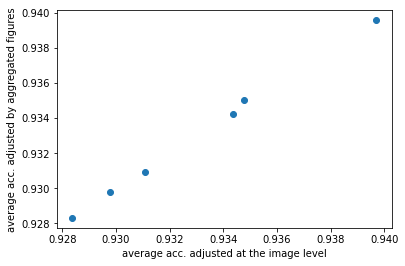

In [22]:
tmp= results.loc[(results['image_level_consistency_without_fov'] == 1), ['image_level_adj_acc', 'aggregated_adj_acc']]
plt.scatter(tmp['image_level_adj_acc'], tmp['aggregated_adj_acc'])
plt.xlabel('average acc. adjusted at the image level')
plt.ylabel('average acc. adjusted by aggregated figures')

In [23]:
tmp

,image_level_adj_acc,aggregated_adj_acc
key,,
fathi2013,0.939706,0.939576
frucci2016,0.934771,0.935043
saroj2020,0.934362,0.934229
singh2016,0.931067,0.930928
singh2017,0.929792,0.929772
bharkad2017,0.928359,0.928307


In [24]:
tmp.corr()

,image_level_adj_acc,aggregated_adj_acc
image_level_adj_acc,1.000000,0.999275
aggregated_adj_acc,0.999275,1.000000
